In [1]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import torch

from src.lstm import ActionClassificationLSTM
from src.video_analyzer import analyze_video, stream_video

In [2]:
cfg = get_cfg()
# load the pre trained model from Detectron2 model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# set confidence threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# in case you don't have GPU device. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cpu only will be extremly slow
device_str = str(device)

cfg.MODEL.DEVICE=device_str
print (cfg.MODEL.DEVICE)
# load model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")


cpu


In [3]:
pose_detector = DefaultPredictor(cfg)
# Load pretrained LSTM model from checkpoint file
lstm_classifier = ActionClassificationLSTM.load_from_checkpoint("models/saved_model.ckpt")
lstm_classifier.eval()
lstm_classifier.to(device)

ActionClassificationLSTM(
  (lstm): LSTM(34, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=6, bias=True)
)

In [4]:
video_generator = analyze_video(pose_detector, lstm_classifier, 'sample_video.mp4')
for progress_update in video_generator:
    print(progress_update)

Video processing started in  1708580365.314123


/Users/jerrylee/Works/action-recognition/venv/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


counter 1 percentage 0
data:0


counter 2 percentage 1
data:1


counter 3 percentage 1
data:1


counter 4 percentage 2
data:2


counter 5 percentage 3
data:3


counter 6 percentage 3
data:3


counter 7 percentage 4
data:4


counter 8 percentage 5
data:5


counter 9 percentage 5
data:5


counter 10 percentage 6
data:6


counter 11 percentage 6
data:6


counter 12 percentage 7
data:7


counter 13 percentage 8
data:8


counter 14 percentage 8
data:8


counter 15 percentage 9
data:9


counter 16 percentage 10
data:10


counter 17 percentage 10
data:10


counter 18 percentage 11
data:11


counter 19 percentage 11
data:11


counter 20 percentage 12
data:12


counter 21 percentage 13
data:13


counter 22 percentage 13
data:13


counter 23 percentage 14
data:14


counter 24 percentage 15
data:15


counter 25 percentage 15
data:15


counter 26 percentage 16
data:16


counter 27 percentage 16
data:16


counter 28 percentage 17
data:17


counter 29 percentage 18
data:18


counter 30 percentage 18

Training dataset overview 

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.

JUMPING,
JUMPING_JACKS,
BOXING,
WAVING_2HANDS,
WAVING_1HAND,
CLAPPING_HANDS.
In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

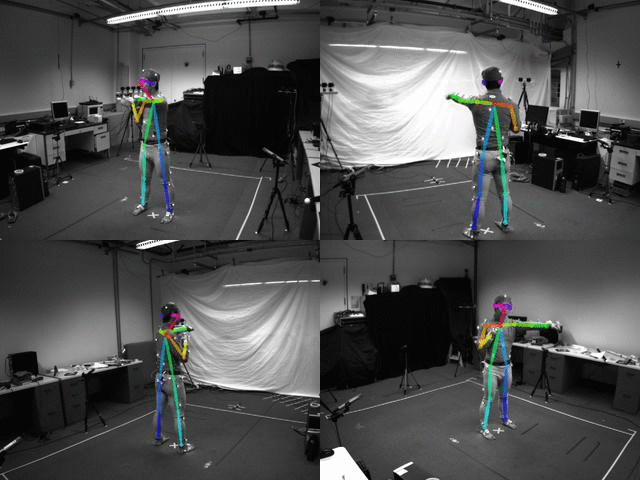


The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.
A single frame's input (where j refers to a joint) is stored as:

[ j0_x, j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.
The following steps were taken:

openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
No further prepossessing was performed.
In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

211200 individual images
n_steps = 32 frames (~=1.5s at 22Hz)
Images with noisy pose detection (detection of >=2 people) = 5132
Training_split = 0.8
Overlap = 0.8125 (26 / 32) ie 26 frame overlap
Length X_train = 22625 * 32 frames
Length X_test = 5751 * 32 frames
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.

In [ ]:
# training model. 
from src.train import do_training_validation
do_training_validation()

Find the last model

In [ ]:
import os
def get_latest_run_version_ckpt_epoch_no(lightning_logs_dir='lightning_logs', run_version=None):
    if run_version is None:
        run_version = 0
        for dir_name in os.listdir(lightning_logs_dir):
            if 'version' in dir_name:
                if int(dir_name.split('_')[1]) > run_version:
                    run_version = int(dir_name.split('_')[1])                
    checkpoints_dir = os.path.join(lightning_logs_dir, 'version_{}'.format(run_version), 'checkpoints')    
    files = os.listdir(checkpoints_dir)
    ckpt_filename = None
    for file in files:
        print(file)
        if file.endswith('.ckpt'):
            ckpt_filename = file        
    if ckpt_filename is not None:
        ckpt_path = os.path.join(checkpoints_dir, ckpt_filename)
    else:
        print('CKPT file is not present')    
    return ckpt_path

In [ ]:
ckpt_path = get_latest_run_version_ckpt_epoch_no()
print('The latest model path: {}'.format(ckpt_path))

Validation

In [ ]:
DATASET_PATH = 'content/RNN-HAR-2D-Pose-database/'
from src.lstm import ActionClassificationLSTM, PoseDataModule
data_root=DATASET_PATH
batch_size=512
data_module = PoseDataModule(data_root=data_root, batch_size=batch_size)
data_module.setup()
val_dataset = data_module.val_dataset

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cpu only will be extremly slow
device_str = str(device)

lstm_classifier = ActionClassificationLSTM.load_from_checkpoint("models/saved_model.ckpt")
lstm_classifier.eval()
lstm_classifier.to(device)
LABELS = {
    0: "JUMPING",
    1: "JUMPING_JACKS",
    2: "BOXING",
    3: "WAVING_2HANDS",
    4: "WAVING_1HAND",
    5: "CLAPPING_HANDS"
}
# Lists to store all predictions and actual labels
all_preds = []
all_targets = []

for data, target in val_dataset:
    model_input = torch.Tensor(np.array(data, dtype=np.float32))
    model_input = torch.unsqueeze(model_input, dim=0)

    y_pred = lstm_classifier(model_input)
    prob = F.softmax(y_pred, dim=1)
    pred_index = prob.data.max(dim=1)[1].numpy()[0]

    all_preds.append(pred_index)

    true_label_index = target[0] if isinstance(target, np.ndarray) else target
    all_targets.append(true_label_index)


In [ ]:
f1 = f1_score(all_targets, all_preds, average='weighted')
print(f'F1 Score: {f1}')

In [ ]:
from src.video_analyzer import stream_video

stream_video('sample_video.mp4')
